In [92]:
import torch
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [93]:
# Importer Un dataset préfait (MNIST)

training_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=T.ToTensor()
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

In [94]:
print(training_dataset)
print(training_dataset.data.shape)
print(training_dataset.targets.shape)
print(training_dataset.targets.unique())
print(training_dataset.targets.bincount())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])


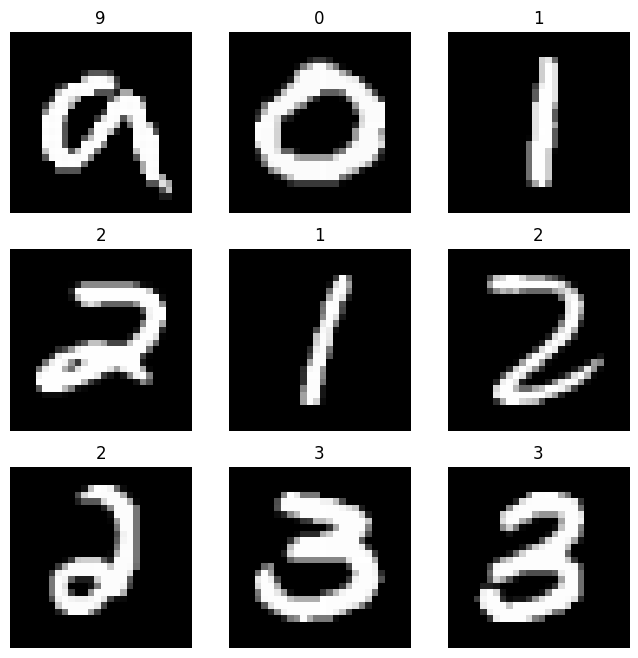

In [95]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [96]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"shape X : {X.shape}")
    print(f"y shape: {y.shape}")
    break

shape X : torch.Size([64, 1, 28, 28])
y shape: torch.Size([64])


In [97]:
train_features, train_labels = next(iter(train_dataloader))
train_features.shape

torch.Size([64, 1, 28, 28])

In [98]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, dims):
        super(MLP, self).__init__()
        self.fcs = nn.ModuleList(
            [nn.Linear(dims[i], dims[i+1]) for i in range(len(dims)-1)]
        )
        self.act = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x) #1 * 28 * 28 -> 1 * 784 
        for layer in self.fcs:
            x  = layer(x)
            x = self.act(x)
        return x

In [99]:
input_dim = 28*28
output_dim = 10 #Nombre de classe
model = MLP([input_dim, 128, 128, output_dim])

In [100]:
model


MLP(
  (fcs): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
  (act): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [101]:
loss_fn = nn.CrossEntropyLoss() # Expect raw logits (!= probabilities)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) 

In [102]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()

    for batch, (X, y) in enumerate(dataloader):

        #Prédiction
        ypred = model(X)
        loss = loss_fn(ypred, y) #Calcul de l'erreur

        #backpropagation
        loss.backward()
        optimizer.step() #W = W - lr * grad
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size * len(X)
            print(f'loss {loss:>7f} [{current:>5d}/{len(dataloader.dataset)}]')

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            ypred = model(X)
            test_loss += loss_fn(ypred, y).item()
            correct += (ypred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss/= len(dataloader)
    correct/=len(dataloader.dataset)
    print(f"Test loss: {test_loss:>8f} | test accuracy {(correct * 100):>7f}")

In [103]:
# epochs = 10
# for t in range(epochs):
#     print(f"Epoch {t+1} ------------------------")
#     train_loop(train_dataloader, model, loss_fn, optimizer)
#     test_loop(test_dataloader, model, loss_fn)
# print("Done!")

Normalisation


In [104]:
# Importer Un dataset préfait (MNIST)

training_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=T.ToTensor()
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

In [105]:
# moyenne et variance des images afin que le model voit mieux en divisant par la moyenne et la variance
from torch.utils.data import ConcatDataset
mean , std = 0 , 0
combined_dataset = ConcatDataset([training_dataset, test_dataset])

for image , label in combined_dataset:
    image = image.view(28*28)
    mean += image.mean().sum()
    std += image.std().sum()

mean /= len(combined_dataset)
std /= len(combined_dataset)

print(f"Mean: {mean}")
print(f"Vriance: {std}")






Mean: 0.13092496991157532
Vriance: 0.30183959007263184


In [106]:
# Importer Un dataset préfait (MNIST)

training_datasetV2 = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=T.Compose([T.ToTensor() , T.Normalize((mean,), (std))])
)

test_datasetV2 = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=T.Compose([T.ToTensor() , T.Normalize((mean,), (std))])
)

In [107]:
# moyenne et variance des images afin que le model voit mieux en divisant par la moyenne et la variance
from torch.utils.data import ConcatDataset
mean, std = 0, 0
combined_dataset = ConcatDataset([training_datasetV2, test_datasetV2])

for image, label in combined_dataset:
    image = image.view(28*28)
    mean += image.mean().item()
    std += image.std().item()

mean /= len(combined_dataset)
std /= len(combined_dataset)



print(f"Mean: {mean}")
print(f"Variance: {std}")


Mean: 1.2527321385667684e-06
Variance: 1.0000014643941606


In [108]:
training_datasetV2[0]

(tensor([[[-0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338],
          [-0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338],
          [-0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338],
          [-0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.433

In [109]:
# epochs = 10
# for t in range(epochs):
#     print(f"Epoch {t+1} ------------------------")
#     train_loop(train_dataloader, model, loss_fn, optimizer)
#     test_loop(test_dataloader, model, loss_fn)
# print("Done!")

In [110]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"accelerateur {device}")

input_dim = 28*28
output_dim = 10 #Nombre de classe
model = MLP([input_dim, 128, 128, output_dim]).to(device)
loss_fn = nn.CrossEntropyLoss().to(device) # Expect raw logits (!= probabilities)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
model.to(device)

accelerateur cuda


MLP(
  (fcs): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
  (act): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [111]:
# Install tensorboard package
# %pip install tensorboard
# tensorboard --logdir=runs
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/mnist_experiment_1')
def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    model.train()
    epoch_loss = 0
    correct = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return epoch_loss / len(dataloader), correct / len(dataloader.dataset) * 100

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return test_loss / len(dataloader), correct / len(dataloader.dataset) * 100

# Training loop with added graphing
def train_and_test(dataloader_train, dataloader_test, model, loss_fn, optimizer, epochs, batch_size):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train the model
        train_loss, accuracy = train_loop(dataloader_train, model, loss_fn, optimizer, batch_size)
        writer.add_scalars('Loss', {'train': train_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': accuracy}, epoch)

        # Test the model
        test_loss, accuracy = test_loop(dataloader_test, model, loss_fn)
        writer.add_scalars('Loss', {'test': test_loss}, epoch)
        writer.add_scalars('Accuracy', {'test': accuracy}, epoch)

        print(f"Epoch {epoch+1}/{epochs} complete\n")

#train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs, batch_size)


In [112]:
# %load_ext tensorboard
# !tensorboard --logdir=runs

In [113]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), #1 * 28 * 28 -> #32 * 28 * 28
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), #32 * 28 * 28 -> 64 * 28 * 28
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2) #64 * 28 *28 -> 64 * 14 * 14
        )
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10),
        )
    
    def forward(self, x):
        x = self.conv_stack(x)
        x = self.mlp(x)
        return x
        

In [114]:
#initialisation du model

epochs = 10

cnn = CNN().to(device)
loss_fn = nn.CrossEntropyLoss().to(device) # Expect raw logits (!= probabilities)
optimizer = torch.optim.AdamW(cnn.parameters(), lr=1e-3)


writter = SummaryWriter('runs/mnist_experiment_2')
train_and_test(train_dataloader, test_dataloader, cnn, loss_fn, optimizer, epochs, batch_size)

Epoch 1/10
Epoch 1/10 complete

Epoch 2/10
Epoch 2/10 complete

Epoch 3/10
Epoch 3/10 complete

Epoch 4/10
Epoch 4/10 complete

Epoch 5/10
Epoch 5/10 complete

Epoch 6/10
Epoch 6/10 complete

Epoch 7/10
Epoch 7/10 complete

Epoch 8/10
Epoch 8/10 complete

Epoch 9/10
Epoch 9/10 complete

Epoch 10/10
Epoch 10/10 complete



In [115]:
cnn.to("cpu")
torch_input = torch.randn(1, 1, 28, 28) #1 image, 1 channel, 28 * 28 
onn_program = torch.onnx.export(
    cnn,
    torch_input,
    "ModelMehdi.onnx",
    verbose=True,
    input_names=["input"],
    output_names=["output"],
    opset_version=11, #  !! version
    export_params=True,
    do_constant_folding=True,
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    }
)

Input length: 1
Sample input: [tensor([[[[ 4.3022e-01, -1.9820e-01, -4.8226e-01,  5.9292e-02, -6.3567e-01,
           -1.4522e+00,  4.4610e-01, -1.4602e-01, -3.1005e-01,  5.8623e-01,
           -2.7649e-01,  1.0564e+00, -6.2817e-01,  2.0320e+00, -7.3200e-01,
           -1.1162e+00,  6.0374e-03, -1.6962e-01,  7.6106e-01, -9.7956e-01,
           -5.7656e-01, -4.0037e-01, -1.1802e+00, -1.2862e-01, -6.6312e-01,
           -1.2260e+00,  1.1501e+00,  7.9426e-01],
          [ 1.2902e+00,  1.2930e+00, -8.7003e-01, -1.5766e+00, -1.4813e+00,
           -1.4893e+00, -7.3307e-01,  2.8198e+00, -1.0460e+00, -6.1777e-01,
            7.7839e-01, -4.4977e-01,  1.1810e+00,  1.1201e+00, -7.2267e-01,
           -6.5290e-01,  7.7540e-01, -9.2666e-01, -3.8030e-01, -1.1868e+00,
            5.6334e-01,  7.0307e-01, -2.5499e+00, -2.0507e-01,  1.1439e+00,
           -2.8508e-01,  1.3555e+00,  1.6358e+00],
          [ 9.6371e-01, -5.0703e-01, -7.5683e-01,  1.0987e+00,  5.7589e-01,
           -1.9137e+00, -4.7414

AssertionError: Tensor-likes are not close!

Mismatched elements: 10 / 10 (100.0%)
Greatest absolute difference: 131.59054565429688 at index (9,) (up to 0.001 allowed)
Greatest relative difference: 1.2952085733413696 at index (2,) (up to 0.001 allowed)